In [2]:
# For Google Colab: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


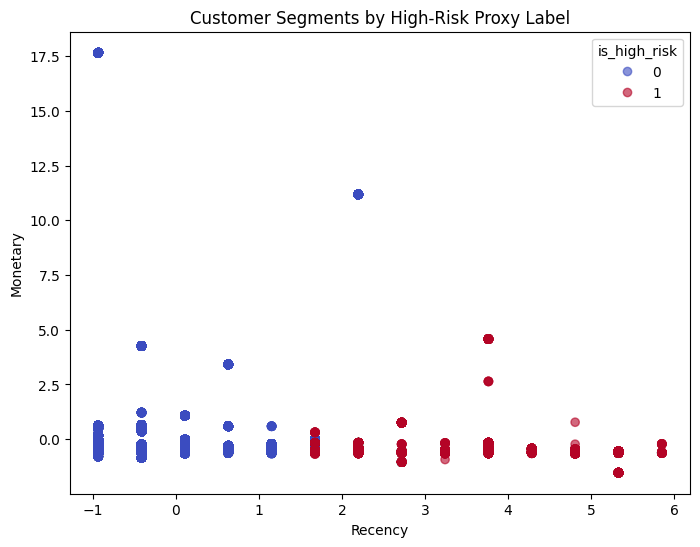

1684

In [3]:

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import gc

# Function to aggregate features per customer
def customer_aggregator(X, y=None, fit=False):
    X = X.copy()
    if fit:
        agg_df = X.groupby('CustomerId').agg({
            'Amount': ['sum', 'mean', 'count', 'std'],
            'TransactionId': 'nunique'
        }).reset_index()
        agg_df.columns = [
            'CustomerId',
            'Total_Transaction_Amount',
            'Avg_Transaction_Amount',
            'Transaction_Count',
            'Std_Transaction_Amount',
            'Unique_Transaction_Count'
        ]
        agg_df['Std_Transaction_Amount'] = agg_df['Std_Transaction_Amount'].fillna(0)
        customer_aggregator.agg_df = agg_df
        return None
    X = X.merge(customer_aggregator.agg_df, on='CustomerId', how='left')
    return X

# Function to extract temporal features
def temporal_feature_extractor(X, y=None, fit=False):
    X = X.copy()
    X['TransactionStartTime'] = pd.to_datetime(X['TransactionStartTime'])
    X['Transaction_Hour'] = X['TransactionStartTime'].dt.hour
    X['Transaction_Day'] = X['TransactionStartTime'].dt.day
    X['Transaction_Month'] = X['TransactionStartTime'].dt.month
    X['Transaction_Year'] = X['TransactionStartTime'].dt.year
    return X

# Function to encode categorical variables
def categorical_encoder(X, y=None, fit=False, categorical_columns=None):
    X = X.copy()
    if fit:
        categorical_encoder.encoders = {}
        for col in categorical_columns:
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoder.fit(X[[col]])
            categorical_encoder.encoders[col] = encoder
        return None
    for col in categorical_columns:
        encoded = categorical_encoder.encoders[col].transform(X[[col]])
        encoded_df = pd.DataFrame(
            encoded,
            columns=[f"{col}_{cat}" for cat in categorical_encoder.encoders[col].categories_[0]],
            index=X.index
        )
        X = X.drop(col, axis=1)
        X = pd.concat([X, encoded_df], axis=1)
    return X

# Function to handle missing values
def missing_value_handler(X, y=None, fit=False, numerical_columns=None, categorical_columns=None):
    X = X.copy()
    if fit:
        missing_value_handler.num_imputer = SimpleImputer(strategy='mean')
        missing_value_handler.cat_imputer = SimpleImputer(strategy='most_frequent')
        if numerical_columns:
            missing_value_handler.num_imputer.fit(X[numerical_columns])
        if categorical_columns:
            missing_value_handler.cat_imputer.fit(X[categorical_columns])
        return None
    if numerical_columns:
        X[numerical_columns] = missing_value_handler.num_imputer.transform(X[numerical_columns])
    if categorical_columns:
        X[categorical_columns] = missing_value_handler.cat_imputer.transform(X[categorical_columns])
    return X

# Function to standardize numerical features
def numerical_standardizer(X, y=None, fit=False, numerical_columns=None):
    X = X.copy()
    if fit:
        numerical_standardizer.scaler = StandardScaler()
        numerical_standardizer.scaler.fit(X[numerical_columns])
        return None
    X[numerical_columns] = numerical_standardizer.scaler.transform(X[numerical_columns])
    return X

# Function to calculate RFM metrics
def rfm_calculator(X, y=None, fit=False):
    X = X.copy()
    X['TransactionStartTime'] = pd.to_datetime(X['TransactionStartTime'])
    if fit:
        # Set snapshot date as max TransactionStartTime + 1 day
        snapshot_date = X['TransactionStartTime'].max() + pd.Timedelta(days=1)
        rfm_calculator.snapshot_date = snapshot_date

        # Calculate RFM metrics per CustomerId
        rfm_df = X.groupby('CustomerId').agg({
            'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,  # Recency
            'TransactionId': 'count',  # Frequency
            'Amount': 'sum'  # Monetary
        }).reset_index()
        rfm_df.columns = ['CustomerId', 'Recency', 'Frequency', 'Monetary']

        # Handle negative Monetary values by shifting to positive range
        rfm_df['Monetary'] = rfm_df['Monetary'] + abs(rfm_df['Monetary'].min()) + 1
        rfm_calculator.rfm_df = rfm_df
        return None
    X = X.merge(rfm_calculator.rfm_df, on='CustomerId', how='left')
    return X

# Function to cluster customers based on RFM
def rfm_clustering(X, y=None, fit=False):
    X = X.copy()
    rfm_features = ['Recency', 'Frequency', 'Monetary']
    if fit:
        # Scale RFM features
        scaler = StandardScaler()
        rfm_scaled = scaler.fit_transform(X[rfm_features])

        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=3, random_state=42)
        kmeans.fit(rfm_scaled)

        # Store scaler and kmeans model
        rfm_clustering.scaler = scaler
        rfm_clustering.kmeans = kmeans

        # Identify high-risk cluster (lowest Frequency, then lowest Monetary)
        rfm_df = X[['CustomerId'] + rfm_features].copy()
        rfm_df['Cluster'] = kmeans.labels_
        cluster_stats = rfm_df.groupby('Cluster').agg({
            'Frequency': 'mean',
            'Monetary': 'mean'
        }).reset_index()
        cluster_stats = cluster_stats.sort_values(['Frequency', 'Monetary'], ascending=[True, True])
        high_risk_cluster = cluster_stats['Cluster'].iloc[0]
        rfm_clustering.high_risk_cluster = high_risk_cluster

        # Assign high-risk labels
        rfm_df['is_high_risk'] = (rfm_df['Cluster'] == high_risk_cluster).astype(int)
        rfm_clustering.rfm_labels = rfm_df[['CustomerId', 'is_high_risk']]
        return None
    # Scale RFM features
    X[rfm_features] = rfm_clustering.scaler.transform(X[rfm_features])
    # Predict clusters
    X['Cluster'] = rfm_clustering.kmeans.predict(X[rfm_features])
    # Assign high-risk labels
    X = X.merge(rfm_clustering.rfm_labels, on='CustomerId', how='left')
    X['is_high_risk'] = X['is_high_risk'].fillna(0).astype(int)
    return X

# Wrapper class to integrate functions into Pipeline
class FunctionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func, **kwargs):
        self.func = func
        self.kwargs = kwargs

    def fit(self, X, y=None):
        self.func(X, y, fit=True, **self.kwargs)
        return self

    def transform(self, X, y=None):
        return self.func(X, y, fit=False, **self.kwargs)

# Define columns
numerical_columns = [
    'Amount', 'Value', 'Total_Transaction_Amount', 'Avg_Transaction_Amount',
    'Transaction_Count', 'Std_Transaction_Amount', 'Transaction_Hour',
    'Transaction_Day', 'Transaction_Month', 'Transaction_Year',
    'Recency', 'Frequency', 'Monetary'
]
categorical_columns = [
    'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
    'ProductCategory', 'ChannelId', 'PricingStrategy'
]

# Define the pipeline
pipeline = Pipeline([
    ('customer_aggregator', FunctionTransformer(customer_aggregator)),
    ('temporal_features', FunctionTransformer(temporal_feature_extractor)),
    ('rfm_calculator', FunctionTransformer(rfm_calculator)),
    ('rfm_clustering', FunctionTransformer(rfm_clustering)),
    ('missing_values', FunctionTransformer(
        missing_value_handler,
        numerical_columns=numerical_columns,
        categorical_columns=categorical_columns
    )),
    ('categorical_encoder', FunctionTransformer(
        categorical_encoder,
        categorical_columns=categorical_columns
    )),
    ('numerical_standardizer', FunctionTransformer(
        numerical_standardizer,
        numerical_columns=numerical_columns
    ))
])

# Load a sample of the data to save RAM
df = pd.read_csv("/content/drive/My Drive/kifiya5/data.csv", nrows=10000)  # adjust nrows as needed for RAM
processed_df = pipeline.fit_transform(df)

# Visualize RFM clusters and high-risk label
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    processed_df['Recency'],
    processed_df['Monetary'],
    c=processed_df['is_high_risk'],
    cmap='coolwarm',
    alpha=0.6
)
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Customer Segments by High-Risk Proxy Label')
plt.legend(*scatter.legend_elements(), title="is_high_risk")
plt.show()

# Clean up to free RAM
del df, processed_df
gc.collect()